In [70]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder





## Data loading and setting up

In [71]:
df = pd.read_csv("final_train_data.csv")
df = df.astype({col: 'category' for col in df.select_dtypes(include='object').columns})

In [72]:
df.dtypes

Distance (cm)                     float64
Illuminance (lx)                  float64
amplitude                         float64
frequency                         float64
Magnetic field x (µT)             float64
Magnetic field y (µT)             float64
Magnetic field z (µT)             float64
Acceleration x (m/s^2)            float64
Acceleration y (m/s^2)            float64
Acceleration z (m/s^2)            float64
Gyroscope x (rad/s)               float64
Gyroscope y (rad/s)               float64
Gyroscope z (rad/s)               float64
Pressure (hPa)                    float64
Linear Acceleration x (m/s^2)     float64
Linear Acceleration y (m/s^2)     float64
Linear Acceleration z (m/s^2)     float64
Common time (s)                   float64
Activity                         category
Mood                                int64
Arousal                             int64
Social engagement                   int64
Noise Level                         int64
Concentration Level               

In [73]:
y = df["Activity"]
X = df.drop(["Activity"],axis=1)
le = LabelEncoder()
y = le.fit_transform(y)



In [74]:
val_df = pd.read_csv("val_data.csv.gz")
val_df = val_df.astype({col: 'category' for col in val_df.select_dtypes(include='object').columns})
y_val = val_df["Activity"]
X_val = val_df.drop(["Activity"],axis=1)
y_val = le.transform(val_df["Activity"])



In [75]:
test_df = pd.read_csv("test_data.csv.gz")
test_df = test_df.astype({col: 'category' for col in test_df.select_dtypes(include='object').columns})
y_test = test_df["Activity"]
X_test = test_df.drop(["Activity"],axis=1)
y_test = le.transform(test_df["Activity"])


In [76]:

num_features  = X.select_dtypes(include ="number").columns
cat_features = X.select_dtypes(include = "category").columns
prep = ColumnTransformer([("num",StandardScaler(),num_features), ("cat",OneHotEncoder(handle_unknown="ignore"),cat_features)])


## Hyperparameter tuning

#### Create spaces

In [77]:
#lightgbm
space_lgbm = [Real(0.01,0.1,name = "learning_rate"),
         Integer(31,128, name = "num_leaves"),
         Integer(20,100,name = "min_child_samples"),
         Real(0.6,1.0,name = "feature_fraction"),
         Integer(500,2000,name = "n_estimators"),
         Real(0.6,1.0,name = "subsample"),
         Real(0.6,1.0, name = "colsample_bytree"),
         Real(0.0,10.0,name = "lambda_l1"),
         Real(0.0,10.0,name = "lambda_l2"),
         Real(0.0,1.0,name = "min_split_gain")]

space_svc = [
    Real(1e-6, 100.0, prior='log-uniform', name='C'),               
    Real(1e-6, 10.0, prior='log-uniform', name='gamma'),            
    Categorical(['linear', 'rbf', 'poly', 'sigmoid'], name='kernel'),  
    Integer(2, 5, name='degree'),                                   
    Real(0.0, 1.0, name='coef0')]

In [78]:
##lgbm
@use_named_args(space_lgbm)
def objective_lgbm(**params):
    lgbm_pipe = Pipeline([("preproc",prep),("clf",lgb.LGBMClassifier(objective='multiclass', num_class=6,random_state=30,n_jobs=-1,verbosity = -1))])
    lgbm_pipe.fit(X,y)
    y_pred =lgbm_pipe.predict(X_val)
    f1 = f1_score(y_pred,y_val,average="macro")
    return -f1
best = gp_minimize(func = objective_lgbm,dimensions = space_lgbm,n_calls = 10,n_random_starts = 10,random_state = 30)



/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [79]:
for element, param in zip(best.x, space_lgbm):
    print(f"{param.name}:{element}")
print(f"The best score was {-best.fun}")

learning_rate:0.09252801838716393
num_leaves:52
min_child_samples:53
feature_fraction:0.8572247414666647
n_estimators:1560
subsample:0.840028327678892
colsample_bytree:0.9709574140163002
lambda_l1:6.966509490139357
lambda_l2:0.23598830451742497
min_split_gain:0.44022355330164975
The best score was 0.16207154728119066


In [80]:
#svc
##lgbm
@use_named_args(space_svc)
def objective_svc(**params):
    svc_pipe = Pipeline([
    ("preproc", prep),
    ("clf", LinearSVC())
])
    svc_pipe.fit(X,y)
    y_pred =svc_pipe.predict(X_val)
    f1 = f1_score(y_pred,y_val,average="macro")
    return -f1
best = gp_minimize(func = objective_svc,dimensions = space_svc,n_calls = 10,n_random_starts = 10,random_state = 30)



In [81]:
for element, param in zip(best.x, space_svc):
    print(f"{param.name}:{element}")
print(f"The best score was {-best.fun}")

C:21.668250946405884
gamma:3.371307154029529e-05
kernel:rbf
degree:4
coef0:0.706414396663471
The best score was 0.07318027002078133


## Training

#### LightGBM

In [82]:
pipe = Pipeline([("preproc",prep),("clf",lgb.LGBMClassifier(objective='multiclass', num_class=6,random_state=30))])
pipe.fit(X,y)
y_pred =pipe.predict(X_test)     
print(classification_report(y_test,y_pred)) 

/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     31092
           1       0.31      0.87      0.46     18922
           2       0.00      0.00      0.00     34191
           3       0.00      0.00      0.00     35422
           4       0.15      0.31      0.20     26557
           5       0.18      0.19      0.18     40283

    accuracy                           0.17    186467
   macro avg       0.11      0.23      0.14    186467
weighted avg       0.09      0.17      0.11    186467



/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

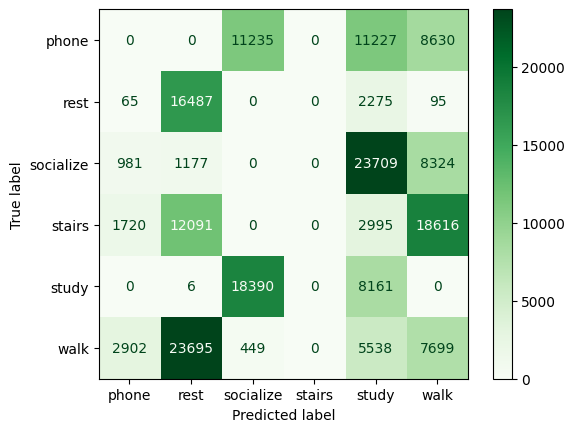

In [83]:
confusion = confusion_matrix(y_test,y_pred)

dis = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=le.classes_)

dis.plot(cmap ="Greens")


#### SVM

In [ ]:
pipe = Pipeline([
    ("preproc", prep),
    ("clf", LinearSVC())
])

pipe.fit(X, y)
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     31092
           1       0.00      0.00      0.00     18922
           2       0.00      0.00      0.00     34191
           3       0.22      1.00      0.36     35422
           4       0.00      0.00      0.00     26557
           5       1.00      0.00      0.00     40283

    accuracy                           0.19    186467
   macro avg       0.20      0.17      0.06    186467
weighted avg       0.26      0.19      0.07    186467



/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/christophlaute/Data Mining Project/Data-Mining-Project-1/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

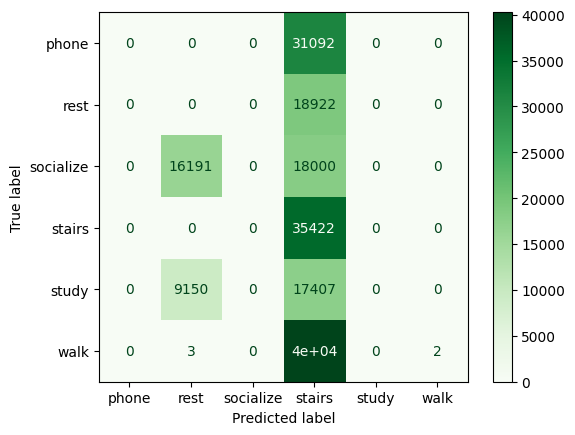

In [ ]:
confusion = confusion_matrix(y_test, y_pred)  


dis = ConfusionMatrixDisplay(confusion_matrix=confusion,display_labels=le.classes_)

dis.plot(cmap ="Greens")